# Optimal Pricing Strategy

We use a **Logistic Regression** to model purchase probability. This provides a model for the demand. We then use the **optimal price equation** to find the optimal price value, which matches marginal revenue to marginal cost. We observe that the optimal strategy sacrifices demand for a substantial gain in revenue. 

We then explore a **constrained optimization** approach, where we impose a lower bound in the demand, in order to find a strategy that optimizes profit without compromising demand.

Finally, we use the **bootstrap** method to verify that stastistical fluctuations stay within the predicted confidence intervals.

### Modelling demand with a logistic regression

For a logistic regression, the purchase probability (demand) can be expressed as
$$
    D(x, f) = \frac{1}{1+\exp(-Z(x) - \gamma f)}
$$
where $x$ is the full set of features (excluding `bag_total_price`), and 
$$
   Z(x) = \theta^T\cdot x + \textrm{intercept} - \gamma f,
$$
where $\theta$ and $\textrm{intercept}$ are the model parameters. $\gamma$ is the model parameter associated to `bag_total_price`. We call $Z$ the **utility** function, as it is what determines, besides price, the propensity of a customer to purchase the good. It is noteworty the fact that $Z(x)$ is independent of `bag_total_price`. The Linear Regression model makes it simple to disentangle these quantities due to the linearity of the activation signal.

Also, we have not included `bag_base_price` in the regression, as it is perfectly correlated with `bag_total_price` and also, by the fact that the customer's choice of purchasing the good is conditionally independent of its cost (given the total price).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import dataframe_image as dfi

from scipy.optimize import fsolve, minimize
from scipy.special import expit, logit

from pricing.benchmark import Benchmark
from pricing.models.baseline import LogisticRegressor
from pricing.plots import prob_hist

file_path = 'data/export.xlsx'
df = pd.read_excel(file_path)
df['Bag_Purchased'] = df['Bag_Purchased'].astype(bool)

# Define features and target variable
X = df.drop(['Bag_Purchased'], axis=1)
y = df['Bag_Purchased']

model = LogisticRegressor(max_iter=100000)

model.fit(X, y)

y_pred = model.pipeline.predict(X)

y_pred.mean(), model.model.intercept_[0]

(0.11258145363408521, 0.40792409439306104)

In [2]:
theta = pd.Series(model.model_coefficients())
intercept = model.model.intercept_ 

In [3]:
def price_utility_plot(data, ylabel, cmap=plt.colormaps["gist_rainbow"]):
    fig, ax = plt.subplots(figsize=(7, 3))
    plt.scatter(Z, data['price'], s=.1, color=cmap(data['demand']))
    ax.set_xlabel('Utility')
    ax.set_ylabel(ylabel)
    ax.plot(np.array([-1, 5]), -np.array([-1, 5])/gamma, 'k--', label='odds=1')
    ax.plot(np.array([-1, 5]), (logit(.25) - np.array([-1, 5]))/gamma, color = 'tab:gray', ls='--', label='odds=1/4')
    ax.set_title('Price vs utility')
    fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap), ax=ax)
    ax.set_xlim([-2, 4])
    ax.set_ylim([0, 150])
    ax.legend()
    fig.subplots_adjust(bottom=0.15)
    return fig

### Explore the quality of purchase probability model

In [6]:
# Compute contrubutions from other features
X_transf = pd.DataFrame(
    model.pipeline.named_steps['preprocessor'].transform(X),
    columns = model.get_feature_names()
)
theta = pd.Series(model.model_coefficients())

In [8]:
# This is the full set of predictors, including the sell price
KX = X_transf.dot(theta).rename('kx') + intercept

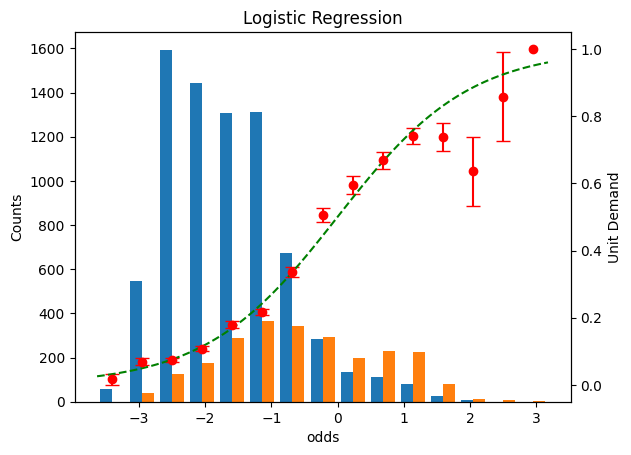

In [9]:
hist = prob_hist(
    predictor=KX,
    target=y,
    nbins=15
)
ax = hist.get_axes()

ax[0].set_title("Logistic Regression")
ax[1].set_ylabel("Unit Demand")
hist.savefig("images/odds.png")

In [10]:
# Sanity check: What's the predicted demand? (observed demand is 24%)
expit(KX).mean()

0.23895724992388995

### How well does the model predict the observed revenue?

We use the model to predict the purchase probability and check how well statistical expectations match the observed values

In [12]:
actuals = pd.concat([X['bag_total_price'].rename('price'), y.rename('demand')], axis=1)

In [13]:
modeled = pd.DataFrame(dict(
    price = X['bag_total_price'].rename('optimal_price'),
    demand = expit(KX).rename('demand')
))

In [19]:
# Compute metrics for the model
cost = X['bag_base_price'].rename('cost')

results = pd.concat({
    "observed": actuals, 
    "modeled": modeled
}, axis=1).astype(float)

def compute_extras(results):
    """
    Adds expecte revenue to dataframe
    """
    margin = results.xs('price', level=1, axis=1).add(-cost, axis='index')
    demand = results.xs('demand', level=1, axis=1)

    # Expected revenue
    profit = margin * demand

    # The Bernoulli variance
    variance = demand*(1 - demand)
    df = pd.concat(dict(
        profit = profit,
        variance = variance
    ), axis=1).reorder_levels([1, 0], axis=1)
    return pd.concat([results, df], axis=1)

def compute_summary(results):
    df = compute_extras(results).mean().unstack()
    styled = df.style\
        .format("{:.2f}")\
        .format('{:.2f}€', subset=["profit", "price"])\
        .format("{:.2%}", subset=['demand'])
    return styled

dfi.export(compute_summary(results), "images/results_modeled.png", dpi=600)

compute_summary(results)

,demand,price,profit,variance
observed,23.90%,64.62€,4.95€,0.00
modeled,23.90%,64.62€,4.95€,0.15


The correctly model predicts the demand, expected profit and average price

### The optimal price equation

For a given product with features $x$ (among them the cost $c$), let $f(x)$ be a pricing strategy. Let the demand at price $f$ of product $x$ be $D(x, f)$, which corresponds to the probability that the client purchases the product given the features $x$ and the set price $f$.

The expected revenue is $R = \mathbb E[f-c]$, where
$$\mathbb E[f-c] = \int dx (f(x)-c) D(x, f) P(x),$$
where $P(x)$ is the frequency with which a product with features $x$ is offered.

The optimal pricing must fullfill the optimality condition
$$
    \left.\frac{\delta \mathbb E[f-c]}{\delta f}\right|_{f=f^*} = \mathbb E\left[D(x, f^*) + (f^* - c)\left.\frac{\partial D}{\partial f}\right|_{f=f^*}\right] = 0
$$

where $\frac{\partial D}{\partial f}$ is the elasticity of the demand at price $f$.

This results in the **optimal price equation** for a given product with features $x$:
$$
    (f^*-c)\left.\frac{\partial D(x, f)}{\partial f}\right|_{f=f^*} + D(x, f^*) = 0
$$


This equation has no trivial solution and requires taiolerd numerical methods for each specific demand function $D(x, f)$

Since the optimal price equation is linear in $D$ we can replace the demand by its normalized value, i.e., the probability that a customer purchases the product at given features $x$ and set price $f$, $D(x, f) = P(\textrm{purchase}|x, f)$.

## Prepare the optimal price equation

Let's compute the contribution of all features, leaving aside the contribution from the total price. According to our model, the demand function is given by
$$
    D(x, f) = \textrm{expit}(Z(x) + \gamma f).
$$ 

Since the cost $c=$ `bag_base_price` should not be a part of the feature vector $x$ it is filtered out by the preprocessing pipeline in `X_transf`.

In [20]:
assert 'bag_base_price' not in theta.keys()

The elasticity then becomes
$$
    \frac{\partial D(x, f)}{\partial f} = D(x, f)(1-D(x, f))\gamma
$$
and the optimal price equation can be written as
$$
    (f^*(x)-c) (1-D(x, f^*(x)))\gamma + 1 = 0
$$

In [25]:
# Compute the utility and the price response gamma
Z = (X_transf.drop('bag_total_price', axis=1).dot(theta.drop('bag_total_price')) + intercept).rename('Z')
gamma = theta['bag_total_price']

gamma

-0.020652417016422803

As expected the elasticity is negative, higher prices translate to lower demand

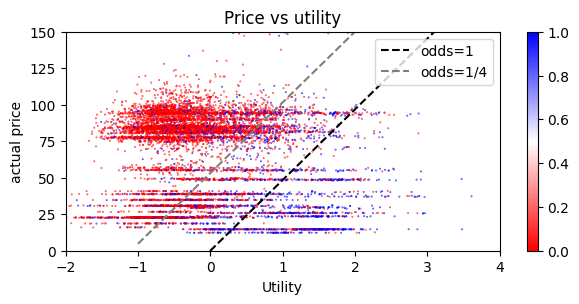

In [26]:
fig = price_utility_plot(actuals.astype(float), ylabel='actual price', cmap=plt.colormaps['bwr_r'])
fig.savefig("images/price_vs_utility.png")

In [27]:
def optimal_price_equation(f, c, z, g):
    return g * (f - c) * (1 - expit(z + g * f)) + 1

# The optimal price
def f(cost, Z):
    return fsolve(optimal_price_equation, x0=1.5 * cost, args=(cost, Z, gamma))[0]

In [42]:
price = pd.concat([cost, Z], axis=1).apply(
        lambda row: f(row['cost'], row['Z']),
    axis=1).rename('price')
prob = expit(Z + gamma * price)
optimal = pd.DataFrame({"price": price, "demand": prob})


results = pd.concat({
    "observed": actuals, 
    "modeled": modeled,
    "optimal": optimal
}, axis=1).astype(float)

results.sample(10)

observed            modeled               optimal          
           price demand       price    demand       price    demand
6705   29.767002    1.0   29.767002  0.696778   94.909512  0.374408
3294   84.269005    0.0   84.269005  0.187163  105.223204  0.129961
4666  123.913002    0.0  123.913002  0.045785  123.646622  0.046026
3734   38.640999    0.0   38.640999  0.280929   79.316750  0.144314
4540   94.248001    0.0   94.248001  0.039964  105.459482  0.031968
9097   94.401001    1.0   94.401001  0.135502  109.506053  0.102927
7118   78.234001    0.0   78.234001  0.096293   97.879190  0.066309
2055   81.957001    0.0   81.957001  0.192465  103.957003  0.131424
7345   83.708008    0.0   83.708008  0.095520  101.222018  0.068515
308    40.800003    0.0   40.800003  0.103798   75.177687  0.053875

### Explore results

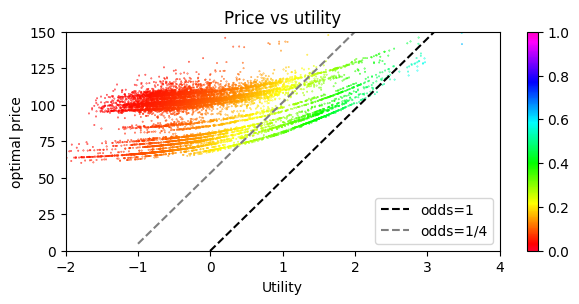

In [43]:
# Look at the price-utility trend
fig = price_utility_plot(optimal, ylabel='optimal price')
fig.savefig("images/optimal_vs_utility.png")

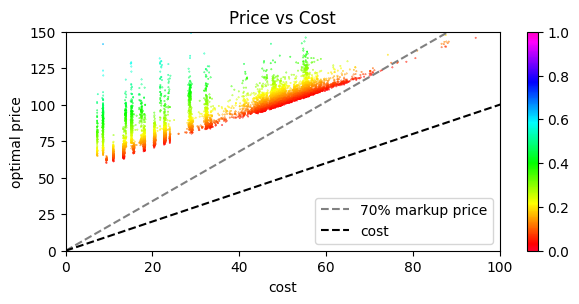

In [44]:
def price_cost_plot(data, ylabel, cmap=plt.colormaps['gist_rainbow']):
    fig, ax = plt.subplots(figsize=[7, 3])
    ax.scatter(cost, data['price'], s=.1, color=cmap(data['demand']))
    ax.set_xlabel('cost')
    ax.set_ylabel(ylabel)
    line = np.array([0, 150])
    ax.plot(line, 1.7 * line, c='gray', ls='--', label='70% markup price')
    ax.plot(line, line, 'k--', label='cost')
    fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap), ax=ax)
    
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 150])
    ax.set_title("Price vs Cost")
    ax.legend()
    fig.subplots_adjust(bottom=0.15)
    
    return fig
fig = price_cost_plot(optimal, ylabel='optimal price')
fig.savefig("images/optimal_vs_cost.png")

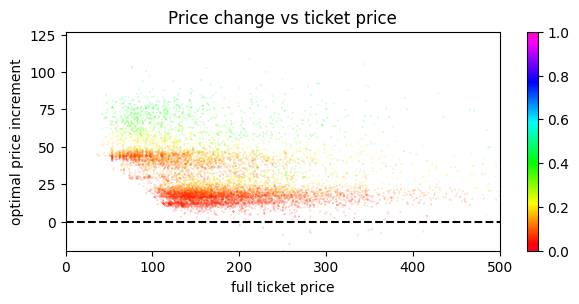

In [45]:
def price_change_plot(data, model, cmap=plt.colormaps['gist_rainbow']):
    fig, ax = plt.subplots(figsize=[7, 3])
    
    x = X['price'] + X['bag_total_price']
    y = X['price'] + data['price'] - x
    ax.scatter(x, y, label='demand', s=.01, c=cmap(data['demand']))
    # ax.scatter(x[~y], results['price'][~y] + results['optimal_price'][~y] - x[~y], label='not purchased', s=.01)
    ax.set_xlabel('full ticket price')
    ax.set_ylabel(f'{model} price increment')
    ax.plot([0, 600], [0, 0], 'k--')
    ax.set_xlim([0, 500])

    ymax = y.max()
    ymin = y.min()
    ax.set_ylim([ymin, ymax])
    fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap), ax=ax)
    ax.set_title("Price change vs ticket price")
    fig.subplots_adjust(bottom=0.15)
    return fig

fig = price_change_plot(optimal, model='optimal')
fig.savefig("images/optimal_change.png")

In [46]:
dfi.export(compute_summary(results).hide('modeled'), "images/results_optimal.png", dpi=600)
compute_summary(results)

,demand,price,profit,variance
observed,23.90%,64.62€,4.95€,0.00
modeled,23.90%,64.62€,4.95€,0.15
optimal,13.96%,95.27€,8.84€,0.11


**We see that the total number of bags purchased would drop from 24% to 14%. This may be unacceptable**

## Constrained optimization formulation


We need to maximize the profit subject to keeping the demand above a certain threshold

$$
\begin{align}
    & \textrm{maximize}_{f(x)} & &\mathbb{E}\left[(f(x) - c) D(x, f(x)\right]\\
    & \textrm{subject~to} & & \mathbb{E}\left[D(x, f(x))\right] > k
\end{align}
$$

We'll use a soft constraint for this optimization
$$
\begin{align}
    L[f] = \mathbb{E}\left[(c-f(x)) D(x, f(x)\right] + e^{\lambda(k - \mathbb{E}[D(x, f(x)])}
\end{align}
$$


In [47]:
# Set the target demand as the current
k = y.mean()

# Set a strong penalty
lamb = 100

In [48]:
# Define the Lagrangian

# Function to be minimized
def L(f):
    # The array of probabilities
    prob = expit(Z + gamma * f(Z, cost))

    # The constraint. Should be negative
    constraint = (k - prob.mean()) 

    # The objective function with an exponential penalty
    out = ((cost - f(Z, cost)) * prob).mean() + np.exp(lamb * constraint)
    return out

# Define a quadratic ansatz function f(z, cost)
def func(z, cost, a, b, c, d, e, f):
    return a*z**2 + b * z * cost + c * cost** 2 + d * z + e * cost + f

# Define the objective
def objective(params):
    a, b, c, d, e, f = params
    return L(lambda z, cost: func(z, cost, a, b, c, d, e, f))

# Initial guess for the parameters a, b, c, d, e, f
initial_guess = [1/np.power(Z, 2).mean(), 1/(Z * cost).mean(), 1/np.power(cost, 2).mean(), 1/Z.mean(), 1/cost.mean(), .1]

# Call the minimize function
res = minimize(objective, initial_guess, method='Nelder-Mead')

# Use this result as a starting point for a new iteration
res = minimize(objective, res.x)

In [49]:
# Using the results of the optimization, this defines the pricing strategy
F = lambda z, cost: func(z, cost, *res.x)

price = F(Z, cost).rename('price')
demand = expit(Z + gamma * price).rename('demand')
constrained = pd.concat([price, demand], axis=1)

In [52]:
results = pd.concat(dict(
    observed = actuals,
    modeled = modeled,
    optimal = optimal,
    constrained = constrained
), axis=1)

dfi.export(compute_summary(results).hide('modeled'), "images/results_constrained.png", dpi=600)

compute_summary(results).hide('modeled')

,demand,price,profit,variance
observed,23.90%,64.62€,4.95€,0.00
optimal,13.96%,95.27€,8.84€,0.11
constrained,24.63%,56.18€,6.13€,0.17


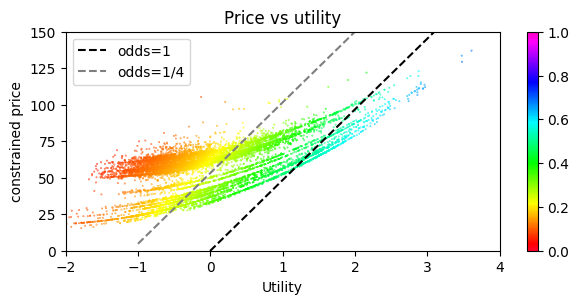

In [53]:
fig = price_utility_plot(constrained, ylabel='constrained price', cmap=plt.colormaps['gist_rainbow'])
fig.savefig("images/constrained_utility.png")

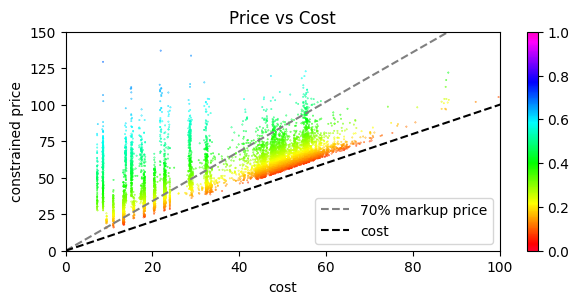

In [54]:
fig = price_cost_plot(constrained, ylabel='constrained price', cmap=plt.colormaps['gist_rainbow'])
fig.savefig("images/constrained_cost.png")

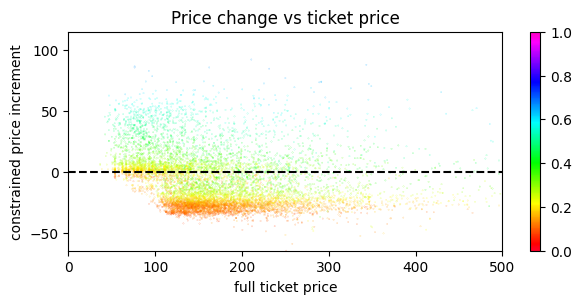

In [55]:
fig = price_change_plot(constrained, model='constrained', cmap=plt.colormaps['gist_rainbow'])
fig.savefig("images/constrained_change.png")

## Risk analysis: Volatility 

In [78]:
compute_summary(results).hide('modeled')

,demand,price,profit,variance
observed,23.90%,64.62€,4.95€,0.00
optimal,13.96%,95.27€,8.84€,0.11
constrained,24.63%,56.18€,6.13€,0.17


In [80]:
rich_results.sort_index(axis=1)

constrained                                  modeled             \
          demand      price    profit  variance    demand      price   
0       0.103846  24.008612  0.601123  0.093062  0.091201  30.973999   
1       0.093775  63.447536  0.511778  0.084981  0.047696  98.583008   
2       0.197950  46.842532  2.375906  0.158766  0.160442  59.228001   
3       0.199969  25.503203  2.428260  0.159981  0.209350  22.712000   
4       0.190583  56.829012  2.181989  0.154261  0.134026  77.146004   
...          ...        ...       ...       ...       ...        ...   
9970    0.159331  41.624092  1.458530  0.133945  0.125256  55.199005   
9971    0.173155  60.063695  1.759893  0.143172  0.111559  84.830002   
9972    0.158005  67.429112  1.440865  0.133039  0.088848  99.127007   
9973    0.155011  64.158215  1.380867  0.130982  0.090250  93.925003   
9974    0.323530  41.700909  7.612944  0.218858  0.374185  30.889002   

                         observed                                  optimal  \
        profit  variance   demand      price     profit variance    demand   
0     1.163178  0.082883     True  30.973999  12.754000        0  0.043875   
1     1.936142  0.045421     True  98.583008  40.593006        0  0.039294   
2     3.912857  0.134700    False  59.228001   0.000000        0  0.094830   
3     1.957846  0.165523    False  22.712000   0.000000        0  0.096046   
4     4.257474  0.116063    False  77.146004   0.000000        0  0.090370   
...        ...       ...      ...        ...        ...      ...       ...   
9970  2.846949  0.109567    False  55.199005   0.000000        0  0.072287   
9971  3.896754  0.099114    False  84.830002   0.000000        0  0.080126   
9972  3.626499  0.080954    False  99.127007   0.000000        0  0.071627   
9973  3.490416  0.082105    False  93.925003   0.000000        0  0.069974   
9974  4.759254  0.234170    False  30.889002   0.000000        0  0.185518   

                                       
           price     profit  variance  
0      68.862415   2.221933  0.041950  
1     108.390962   1.980478  0.037750  
2      88.333245   5.072762  0.085837  
3      66.925191   5.144708  0.086821  
4      98.610976   4.810492  0.082203  
...          ...        ...       ...  
9970   84.663379   3.772895  0.067061  
9971  102.538188   4.217704  0.073706  
9972  110.466256   3.735772  0.066496  
9973  107.313563   3.643080  0.065077  
9974   77.619402  11.028919  0.151101  

[9975 rows x 16 columns]

In [81]:
# Let's compute the expected fluctuations for each model

# Enrich results with extra metrics
rich_results = compute_extras(results)

summary = {}
unit_descr = {}
total_descr = {}

for model in rich_results.columns.get_level_values(level=0).unique():
    res = rich_results.xs(model, level=0, axis=1)

    mean = res.mean()
    mean['std'] = np.sqrt(mean['variance'])

    unit_descr[model] = {
        "Expected revenue per ticket": f"{mean['profit']:.2f}€ ± {mean['std']:.2f}€",
        "68% (1-sigma) Confidence interval": f"[{(mean['profit'] - mean['std']):.2f}€, {(mean['profit'] + mean['std']):.2f}€]",
        "95% (2-sigma) Confidence interval": f"[{(mean['profit'] - 2*mean['std']):.2f}€, {(mean['profit'] + 2*mean['std']):.2f}€]"
    }

    total_descr[model] = {
        "Total expected revenue in the period": f"{mean['profit']*len(res):.0f}€ ± {mean['std']*len(res):.0f}€",
        "68% (1-sigma) Confidence interval": f"[{(mean['profit'] - mean['std'])*len(res):.0f}€, {(mean['profit'] + mean['std'])*len(res):.0f}€]",
        "95% (2-sigma) Confidence interval": f"[{(mean['profit'] - 2*mean['std'])*len(res):.0f}€, {(mean['profit'] + 2*mean['std'])*len(res):.0f}€]"        
    }
    summary[model] = mean

summary = pd.concat(summary, axis=1)

unit_descr = pd.DataFrame(unit_descr)
unit_descr.columns.name = "Unit profit for model"

total_descr = pd.DataFrame(total_descr)
total_descr.columns.name = "Gross profit for model"

dfi.export(unit_descr, "images/summary.png", dpi=600)
unit_descr

Unit profit for model,observed,modeled,optimal,constrained
Expected revenue per ticket,4.95€ ± 0.00€,4.95€ ± 0.38€,8.84€ ± 0.33€,6.13€ ± 0.41€
68% (1-sigma) Confidence interval,"[4.95€, 4.95€]","[4.57€, 5.33€]","[8.51€, 9.17€]","[5.71€, 6.54€]"
95% (2-sigma) Confidence interval,"[4.95€, 4.95€]","[4.19€, 5.71€]","[8.18€, 9.50€]","[5.30€, 6.95€]"


In [82]:
total_descr

Gross profit for model,observed,modeled,optimal,constrained
Total expected revenue in the period,49376€ ± 0€,49376€ ± 3807€,88175€ ± 3309€,61110€ ± 4122€
68% (1-sigma) Confidence interval,"[49376€, 49376€]","[45569€, 53183€]","[84866€, 91484€]","[56988€, 65232€]"
95% (2-sigma) Confidence interval,"[49376€, 49376€]","[41762€, 56990€]","[81557€, 94793€]","[52866€, 69354€]"


### Use bootstrap to confirm volatility estimates

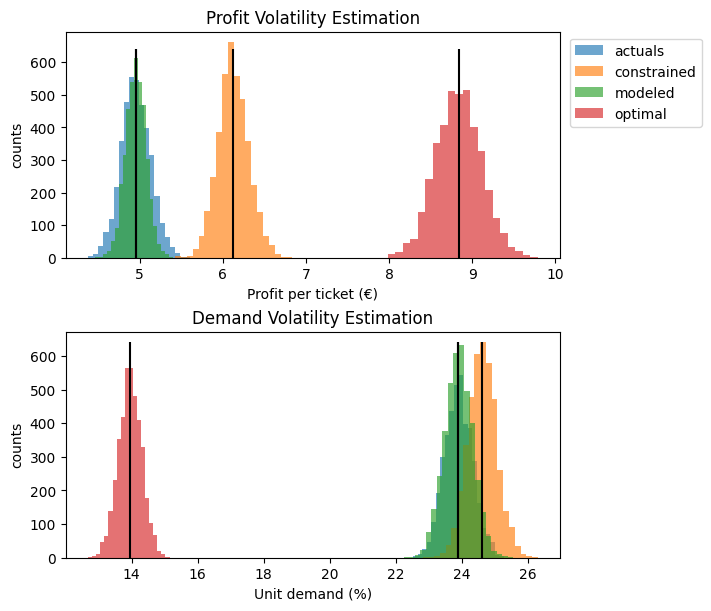

In [31]:
N = 4000
model = 'actuals'

def bootstrap_revenue(results):
    demand = []
    prof = []
    for i in range(N):
        sample = results.sample(len(results), replace=True)                            
        purchased = sample['demand'] > np.random.sample(sample.shape[0])
        profit = (sample['price'] - cost) * purchased
        prof.append(profit.mean())
        demand.append(purchased.mean())
    return pd.DataFrame({'profit': prof, 'demand': demand})


prof = {}

for model in rich_results.columns.get_level_values(level=0).unique():
    prof[model] = bootstrap_revenue(results.xs(model, level=0, axis=1))

df = pd.concat(prof, names=['model']).reset_index().drop(columns='level_1')
ymax = N / 1000 * 160
fig, ax = plt.subplots(2, 1, figsize=[7, 6], layout='constrained')
ax1, ax2 = ax
for name, g in df.groupby('model'):
    plt1 = g['profit'].hist(
        bins=20,
        alpha=0.65,
        label=name,
        ax=ax1,
        grid=False
    )
    plt2 = (100 * g['demand']).hist(
        bins=20,
        alpha=0.65,
        label=name,
        ax=ax2,
        grid=False
    )
    
    ax1.vlines(summary.loc['exp_revenue', name], ymin=0, ymax=ymax, colors='black')
    ax2.vlines(100 * summary.loc['demand', name], ymin=0, ymax=ymax, colors='black')
        
    
plt.grid(False)
ax1.set_title("Profit Volatility Estimation")
ax1.set_xlabel('Profit per ticket (€)')
ax1.set_ylabel('counts')

ax2.set_title("Demand Volatility Estimation")
ax2.set_xlabel('Unit demand (%)')
ax2.set_ylabel('counts')

ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

fig.savefig("images/revenue_histograms.png")
